In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import phate
import scprep
import scipy


import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from sklearn.manifold import MDS


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.models.lit_encoder import LitDistEncoder
from src.data.make_dataset import train_dataloader
from src.data.make_dataset import make_n_sphere_two
from src.data.make_dataset import make_tree
from src.data.make_dataset import make_live_seq
from src.data.make_dataset import make_pbmc
from src.data.make_dataset import make_ipsc
from src.fim_noemb import FIM
import os
from sklearn.decomposition import PCA
import math
import random
import pickle

import h5py
import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn

# Tree Data

In [11]:
# Data Parameters
dataset = "tree"
n_obs = 1500
n_dim = 10
batch_size = 50

# Model param
encoder_layer = [100,50,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 20  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=False #Rescale of PHATE parameters

# Trainer param
max_epochs = 150
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "tree_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [12]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="tree_autoenocder_logp", name=exp_name) if wandb else False

In [8]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)


In [13]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
# train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model, train_dataloaders=train_loader)

Global seed set to 684


[Linear(in_features=10, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 8.7 K 
1 | decoder | Sequential | 242   
---------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.036     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [14]:
#save model (and load model)

torch.save(model.state_dict(),'saved_models/tree_model_1_25_JSD.pt')
#model.load_state_dict(torch.load('saved_models/tree_model_1_22_JSD.pt'))



In [15]:
#JSD function

#"""

def computeJSD(X):
    
    #NOTE: Input for this function is matrix where the rows are log-transformed probabilites

    jsd = torch.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):

        p = X[i,:]
        q = X
        m = (0.5 * (p.exp() + q.exp()))
        

        kone = 0.5 *( (p.exp() * (p - m.log() ) ).sum(dim=1))
        ktwo = 0.5 *( (q.exp() * (q - m.log() ) ).sum(dim=1))
        k = kone + ktwo

        jsd[i,:] = k
     
    jsd.fill_diagonal_(0) #setting diagonal to 0 to avoid nan's
            
    return jsd.to('cuda')
    
"""

def computeJSD(X):
    
    #NOTE: Input for this function is matrix where rows are probabilites

    jsd = torch.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):

        p = X[i,:]
        q = X
        m = (0.5 * (p + q))
        

        kone = 0.5 *( (p * (p.log() - m.log() ) ).sum(dim=1))
        ktwo = 0.5 *( (q * (q.log() - m.log() ) ).sum(dim=1))
        k = kone + ktwo

        jsd[i,:] = k
     
    jsd.fill_diagonal_(0) #setting diagonal to 0 to avoid nan's
            
    return jsd.to('cuda')

"""


"\n\ndef computeJSD(X):\n    \n    #NOTE: Input for this function is matrix where rows are probabilites\n\n    jsd = torch.zeros((X.shape[0],X.shape[0]))\n    for i in range(X.shape[0]):\n\n        p = X[i,:]\n        q = X\n        m = (0.5 * (p + q))\n        \n\n        kone = 0.5 *( (p * (p.log() - m.log() ) ).sum(dim=1))\n        ktwo = 0.5 *( (q * (q.log() - m.log() ) ).sum(dim=1))\n        k = kone + ktwo\n\n        jsd[i,:] = k\n     \n    jsd.fill_diagonal_(0) #setting diagonal to 0 to avoid nan's\n            \n    return jsd.to('cuda')\n\n"

# Evaluate tree data and embed with JSD MDS

In [17]:


tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=8, branch_length=200)
tree_data = torch.tensor(tree_data, requires_grad=True).float().to('cuda')
model.cuda()
model.eval()
pred =  model.encode(tree_data).detach().cpu().numpy()

#Regular MDS
#mds_operator = MDS()
#predemb = mds_operator.fit_transform(pred)
#print(predemb.shape)


#Performing ground JSD MDS
phate_op = phate.PHATE(random_state=42, verbose=False, knn=5).fit(tree_data.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()

gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_tree= mds_operator.fit_transform(gtdist.detach().cpu().numpy())


# Messing around

In [18]:
#Evaluate pytorch model on new data and embed with MDS

#tree_data, tree_phate, tree_clusters = make_tree(n_obs=2000,dim=10,emb_dim=2,knn=knn)
#tree_data = tree_data.to('cuda')
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=8, branch_length=200)
tree_data = torch.tensor(tree_data, requires_grad=True).float().to('cuda')
model.cuda()
model.eval()

#pred = model.encode(tree_data)#.detach().cpu().numpy()
pred =  model.encode(tree_data)
#predist = torch.sqrt( torch.abs(computeJSD(pred + 1e-7)) )
pred = pred.detach().cpu().numpy()


#mds_operator = MDS(dissimilarity='precomputed')
#predemb = mds_operator.fit_transform(predist.detach().cpu().numpy())


In [23]:
#Evaluate Ground Truth with MDS

#tree_data, tree_phate, tree_clusters = make_tree(n_obs=2000,dim=10,emb_dim=2,knn=10)
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=8, branch_length=200)
phate_op = phate.PHATE(random_state=42, verbose=False, knn=5).fit(tree_data)#.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()

print(diff_pot.shape)


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )

mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb = mds_operator.fit_transform(gtdist.detach().cpu().numpy())



torch.Size([1600, 1600])


Text(0, 0.5, 'PHATE axis 2')

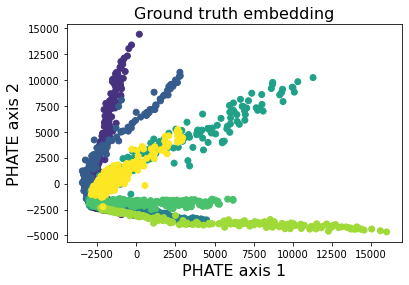

In [65]:

plt.figure()
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phateJSDemb[:,0],phateJSDemb[:,1], c=tree_clusters )
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)



In [43]:
print(phateJSDemb.shape)
print(predemb.shape)

print(pred.shape)
print(phate_dist.shape)
print(diff_pot.shape)

(1500, 2)
(1500, 2)
(1500, 100)
torch.Size([1500, 1500])
torch.Size([1500, 1500])


In [20]:
#Evaluate with PCA

pca = PCA(n_components=2)
print(pred.shape)
pca.fit(pred)


(1500, 50)


PCA(n_components=2)

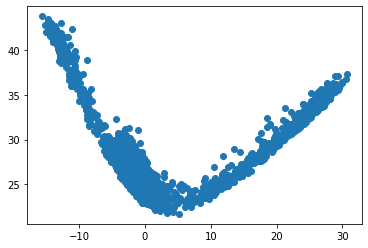

In [9]:

pcapred = pred @ pca.components_.T
plt.figure()
plt.scatter(pcapred[:,0],pcapred[:,1])


torch.Size([1800, 10])
(2, 10)


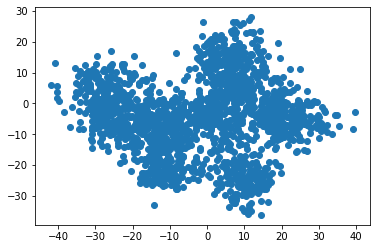

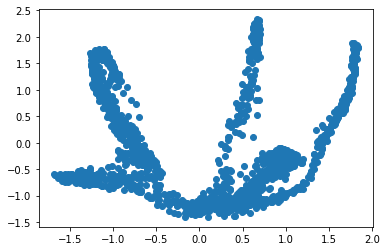

In [84]:
#Evaluate with PCA


tree_data, tree_phate, tree_clusters = make_tree(n_obs=2000,dim=10,emb_dim=2,knn=5)
#tree_data = tree_data.to('cuda')
#model.cuda()
#model.eval()
#pred = model.encode(tree_data).detach().cpu().numpy()

#Ground Truth
pca = PCA(n_components=2)
pca.fit(tree_data.detach().numpy())
print(tree_data.shape)
print(pca.components_.shape)
ntree = tree_data.detach().numpy() @ pca.components_.T

plt.figure()
plt.scatter(ntree[:,0],ntree[:,1])

#Predictions
plt.figure()
plt.scatter(tree_phate[:,0],tree_phate[:,1])



# End of messing around

In [ ]:
#Plotting

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1], c= tree_clusters)
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure(figsize = (14,6))
plt.suptitle("Ground Truth and MDS Embedding",fontweight='bold',fontsize=18)
plt.subplot(121)
plt.title("MDS emebedding of predictions",fontsize=16)
plt.scatter(predemb[:, 0], predemb[:, 1], c= tree_clusters)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


plt.subplot(122)
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phateJSDemb[:,0],phateJSDemb[:,1], c=tree_clusters )
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


np.save("saved_data/5_300_tree_1_25_1500_pred_JSD.npy",pred)
np.save("saved_data/5_300_tree_1_25_1500_pred_MDS_JSD.npy",predemb)
np.save("saved_data/5_300_tree_1_25_1500_ground_truth_JSD.npy",tree_phate)
plt.savefig("Figures/5_300_tree_1_25_1500_ground_truth_JSD.png")


# Compute FIM 

In [18]:

n_obs = tree_data.shape[0]
model.cuda()
fcn = model.encode
tree_data.cuda()
fisher = FIM(tree_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model.eval()
vout = model.encode(tvec).squeeze()
#neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


In [21]:
pcaeivec = vout.squeeze().detach().cpu().numpy()

In [22]:
print(pcaeivec.shape)

(1500, 50)


(1500, 2)
(50, 2)
(1500, 2)


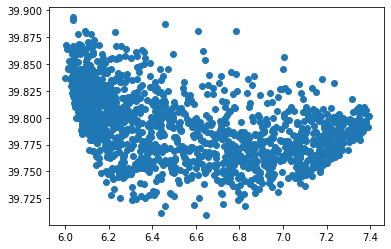

In [23]:
print(neivec.shape)
print(pca.components_.T.shape)
x = pcaeivec @ pca.components_.T
print(x.shape)

plt.scatter(x[:,0],x[:,1])

In [10]:
#Debugging/Nonsense Code
np.random.randint(0,360,1)[0]
print(e[0:5,:])
print(J.shape)
print(e.shape)
rint = np.random.randint(0,e.shape[0],size=10)
print(rint[0])
print(tree_phate.shape)
print(predemb.shape)
print(pred.shape)

"""
#Getting low dimensional eigenvectors
ldimeivec = np.zeros((J.shape[0],J.shape[1]))
for i in range(J.shape[0]):
    vtest = v[i,-1,:] #Get top eigenvector for each sample
    Jtest = J[i,:,:] #Get Jacobian for each sample
    ldimeivec[i,:] = np.expand_dims(Jtest @ vtest,axis=0) #Project down to 2 dimensions
    
print(predemb.shape)
print(ldimeivec.shape)
print(v.shape)
print(v[tind,0,:].shape)
print(predemb[tind,1].shape)

"""

"""
plt.figure()
plt.scatter(predemb[tind,0],predemb[tind,1],c=tind)
plt.quiver(predemb[tind,0],predemb[tind,1],u,vee)
plt.quiver(predemb[tind,0],predemb[tind,1],ut,veet)


        
plt.figure()
#plt.scatter(ldimeivec[:,0],ldimeivec[:,1],marker = ",") #plotting eigenvec [nsamp x dims]
plt.scatter(predemb[tind,0], predemb[tind,1], c= ntrace)
plt.colorbar()
sys.exit()

"""

#plt.subplot(231)
#plt.title("Volume",fontsize=14)
#plt.plot(nvolume)
#plt.xlabel("Data points",fontsize=14)
#plt.ylabel("Normalized volume",fontsize=14)

[[0.0098134  0.00382471 0.00240291 0.00189112 0.00098521 0.00020661
  0.00073298 0.00060296 0.00049979 0.00045258]
 [0.01192276 0.00258915 0.00196463 0.00172241 0.00111712 0.00020554
  0.00035915 0.00049477 0.00064988 0.0009544 ]
 [0.00716486 0.00455612 0.00213124 0.00164425 0.00122007 0.00019486
  0.00035848 0.00100241 0.00059248 0.00066148]
 [0.01050808 0.00449396 0.00243287 0.00145241 0.00109164 0.00095467
  0.00079686 0.00026341 0.00031432 0.00046295]
 [0.00978533 0.00291096 0.00192899 0.0017469  0.00114277 0.00089293
  0.00026672 0.00068958 0.00060362 0.00041497]]
(1500, 50, 10)
(1500, 10)
435
(1500, 2)
(1500, 2)
(1500, 50)


'\nplt.figure()\nplt.scatter(predemb[tind,0],predemb[tind,1],c=tind)\nplt.quiver(predemb[tind,0],predemb[tind,1],u,vee)\nplt.quiver(predemb[tind,0],predemb[tind,1],ut,veet)\n\n\n        \nplt.figure()\n#plt.scatter(ldimeivec[:,0],ldimeivec[:,1],marker = ",") #plotting eigenvec [nsamp x dims]\nplt.scatter(predemb[tind,0], predemb[tind,1], c= ntrace)\nplt.colorbar()\nsys.exit()\n\n'

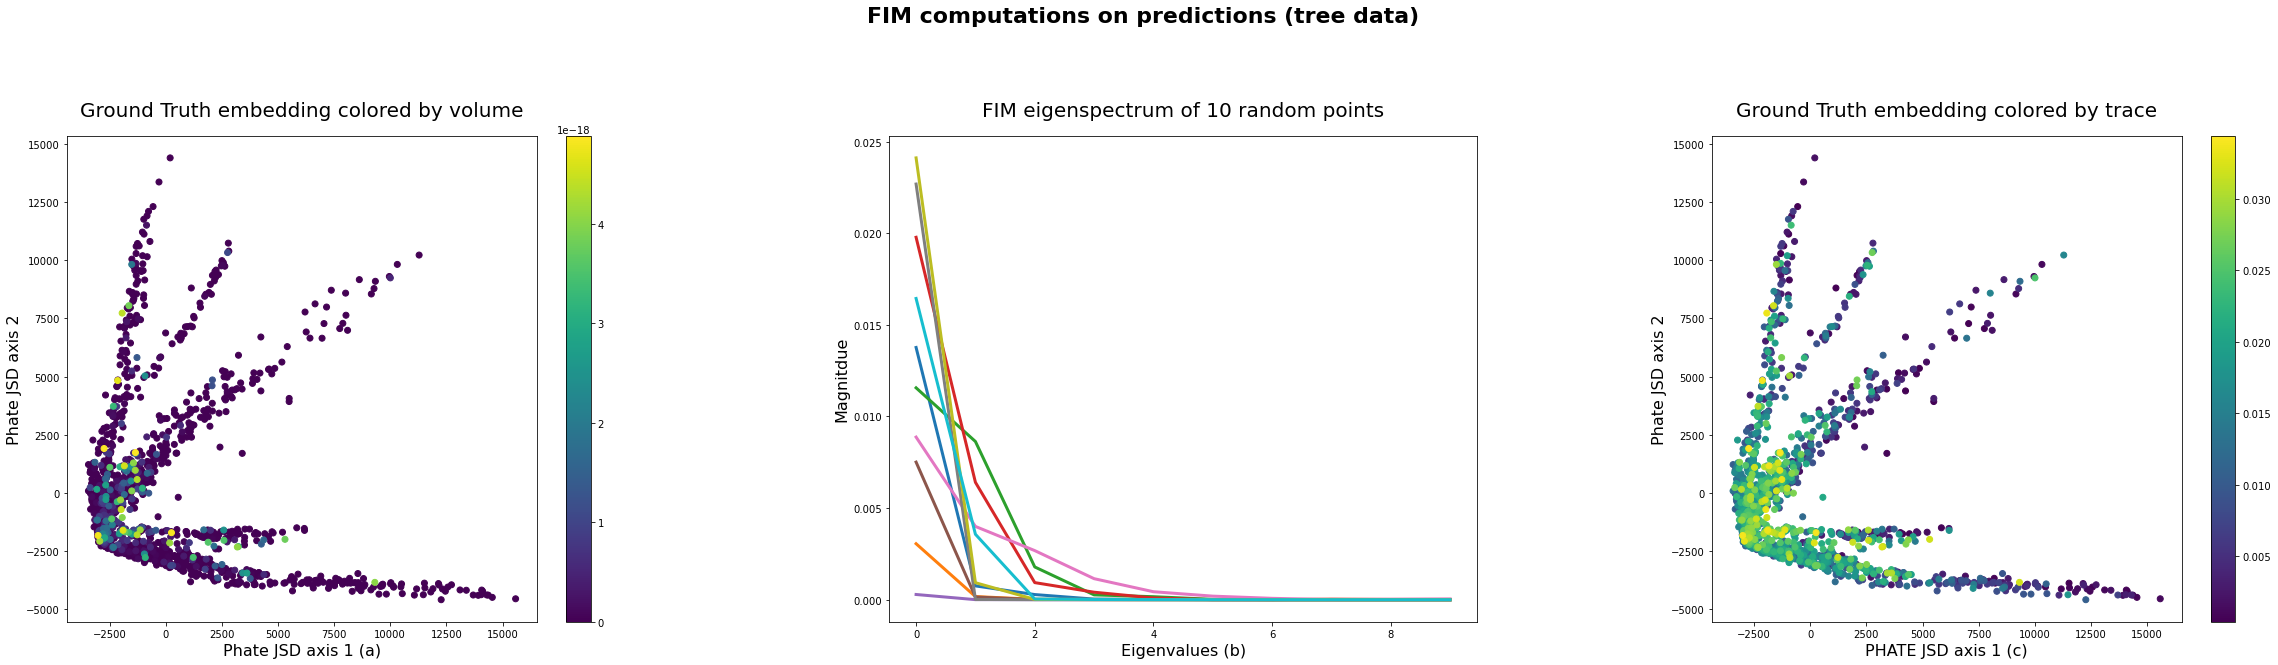

In [42]:

#Pads axis titles
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 


#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


fig = plt.figure(figsize=(40,10))
plt.suptitle("FIM computations on predictions (tree data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=1.0,wspace=0.4,top=0.8)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(131)
plt.title("Ground Truth embedding colored by volume",fontsize=20)
#plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.scatter(phateJSDemb_tree[tind, 0], phateJSDemb_tree[tind, 1], c= nvolume)
plt.xlabel("Phate JSD axis 1 (a)",fontsize=16)
plt.ylabel("Phate JSD axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,n_obs,size=10)
plt.subplot(132)
plt.title("FIM eigenspectrum of 10 random points",fontsize=20)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues (b)",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)


#Trace
#plt.subplot(223)
#plt.title("Encoded embedding colored by trace of FIM",fontsize=16)
#plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
#plt.xlabel("PHATE axis 1",fontsize=16)
#plt.ylabel("PHATE axis 2",fontsize=16)
#plt.colorbar()



#Trace
plt.subplot(133)
plt.title("Ground Truth embedding colored by trace",fontsize=20)
#plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.scatter(phateJSDemb_tree[tind, 0], phateJSDemb_tree[tind, 1], c= ntrace)
plt.xlabel("PHATE JSD axis 1 (c)",fontsize=16)
plt.ylabel("Phate JSD axis 2",fontsize=16)
plt.colorbar()



#Visualization of eignevectors
#reint = np.random.randint(0,tree_phate.shape[0],size=500) #Random 
#plt.subplot(224)
#plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
#plt.scatter(predemb[reint,0],predemb[reint,1],c=tree_clusters[reint])
#plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=20)
#plt.xlabel("embedding axis 1",fontsize=16)
#plt.ylabel("embedding axis 2",fontsize=16)

plt.savefig("Figures/5_300_tree_FIMcomps_1_25_JSD_MDS.png")
np.save("saved_data/8_200_tree_1_25_1500_ground_truth_JSD.npy",phateJSDemb_tree)
np.save("saved_data/8_200_tree_1_25_ind.npy",tind)
np.save("saved_data/8_200_tree_1_25_1500_trace.npy",ntrace)
np.save("saved_data/8_200_tree_1_25_1500_volume.npy",nvolume)

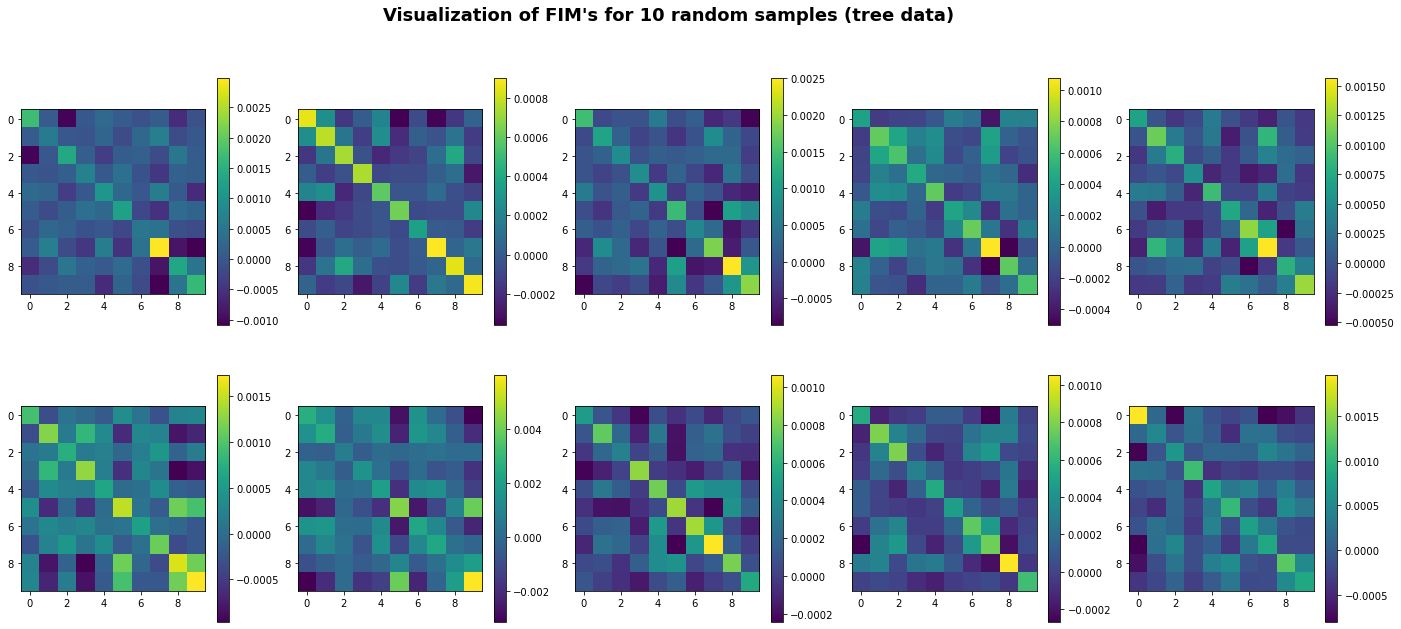

In [12]:
plt.figure(figsize = (24,10))
plt.suptitle("Visualization of FIM's for 10 random samples (tree data)",fontsize=18,fontweight='bold')
for i in range(len(rint)):
    plt.subplot(2,5,i+1)
    plt.imshow(fishermat[rint[i],:,:])
    plt.colorbar()
    
plt.savefig('random_FIMs.png')

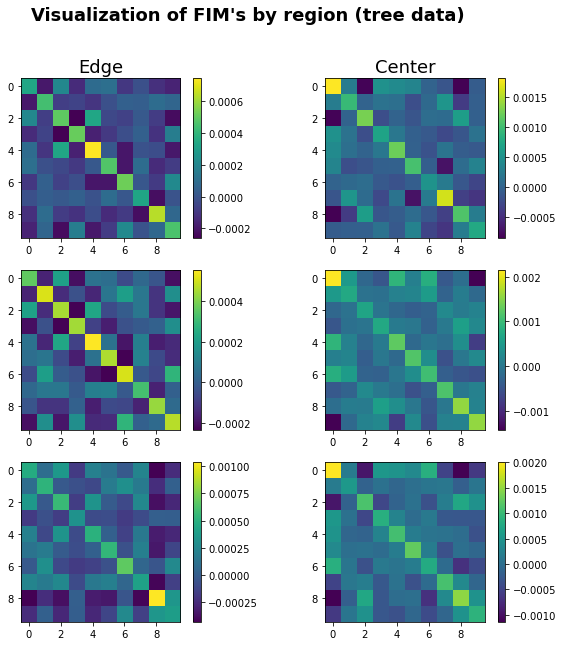

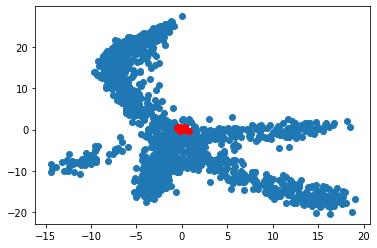

In [11]:
#Compute and sort embedding distances
distind = np.argsort(np.linalg.norm((predemb - predemb.mean(0)),axis=1))
plt.figure(figsize = (10,10))
plt.suptitle("Visualization of FIM's by region (tree data)",fontsize=18,fontweight='bold')

a = int(len(distind)) -1 #specifies index in sorted vector to get edges

for i in range(6):
    plt.subplot(3,2,i+1)
    
    if i == 1 or i == 3 or i == 5: #(for plotting)
        if i == 1:
            plt.title("Center",fontsize=18)
        plt.imshow(fishermat[distind[i],:,:])
        plt.colorbar()
        
    else:
        if i == 0: #(for plotting)
            plt.title("Edge",fontsize=18)
        plt.imshow(fishermat[distind[a],:,:])
        plt.colorbar()
        
    a = a - 1
    
plt.savefig("Figures/5_300_tree_regional_FIMs_1_17.png")

plt.figure()
plt.scatter(predemb[:,0],predemb[:,1])
plt.scatter(predemb[distind[:10],0],predemb[distind[:10],1],c='red')

# Sphere Data

In [55]:
# Data Parameters
dataset = "sphere"
n_obs = 1500
n_dim = 10
batch_size = 100

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 10 # PHATE kernel number of Nearest Neighbors.
logp=True

# Trainer param
max_epochs = 100
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "sphere_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [56]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="sphere_autoenocder_logp", name=exp_name) if wandb else False

In [57]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

In [58]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model_sphere = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_sphere, train_dataloaders=train_loader)

Global seed set to 847


[Linear(in_features=10, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 16.2 K
1 | decoder | Sequential | 242   
---------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [62]:
#save model (and load model)

torch.save(model_sphere.state_dict(),'saved_models/sphere_model_1_22.pt')
#model.load_state_dict(torch.load('saved_models/sphere_model_1_18.pt'))

In [60]:
#Evaluate pytorch model on new data

sphere_data, sphere_phate = make_n_sphere_two(n_obs=n_obs,dim=10,emb_dim=2,knn=knn)
sphere_data = sphere_data.to('cuda')
model_sphere.cuda()
model_sphere.eval()
pred = model_sphere.encode(sphere_data).detach().cpu().numpy()

mds_operator = MDS()
predemb = mds_operator.fit_transform(pred)


In [63]:
phate_op = phate.PHATE(random_state=42, verbose=False, n_components=emb_dim, knn=10).fit(sphere_data.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()

mds_operator = MDS()
sphereJSDemb = mds_operator.fit_transform(diff_pot)

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:506: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


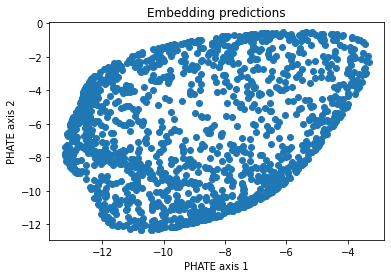

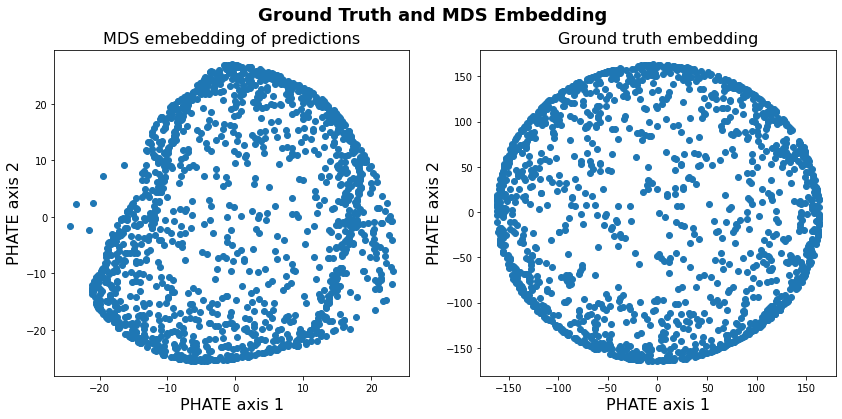

In [64]:


plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure(figsize = (14,6))
plt.suptitle("Ground Truth and MDS Embedding",fontweight='bold',fontsize=18)
plt.subplot(121)
plt.title("MDS emebedding of predictions",fontsize=16)
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.subplot(122)
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(sphereJSDemb[:,0],sphereJSDemb[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


np.save("saved_data/1500_sphere_1_22_1500_pred.npy",pred)
np.save("saved_data/1500_sphere_1_22_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_sphere_1_22_1500_ground_truth.npy",sphereJSDemb)
plt.savefig("Figures/1500_sphere_1_22_1500_ground_truth.png")

In [65]:
print(sphere_data.shape)

torch.Size([1500, 10])


In [66]:

#Compute FIM 
n_obs = sphere_data.shape[0]
model_sphere.cuda()
fcn = model_sphere.encode
fisher = FIM(sphere_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model_sphere.eval()
vout = model_sphere.encode(tvec).squeeze()
neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())




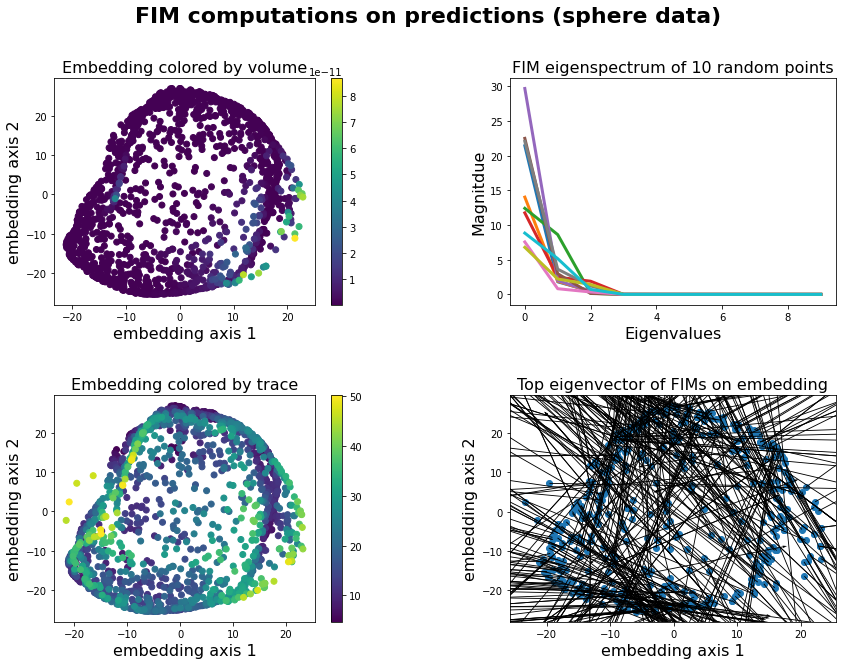

In [67]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


plt.figure(figsize=(14,10))
plt.suptitle("FIM computations on predictions (sphere data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.4)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(221)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,n_obs,size=10)
plt.subplot(222)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)



#Trace
plt.subplot(223)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.colorbar()



#Visualization of eignevectors
reint = np.random.randint(0,sphere_phate.shape[0],size=500)  
plt.subplot(224)
plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
plt.scatter(predemb[reint,0],predemb[reint,1])
plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=15)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.savefig("Figures/1500_sphere_FIMcomps_1_22.png")

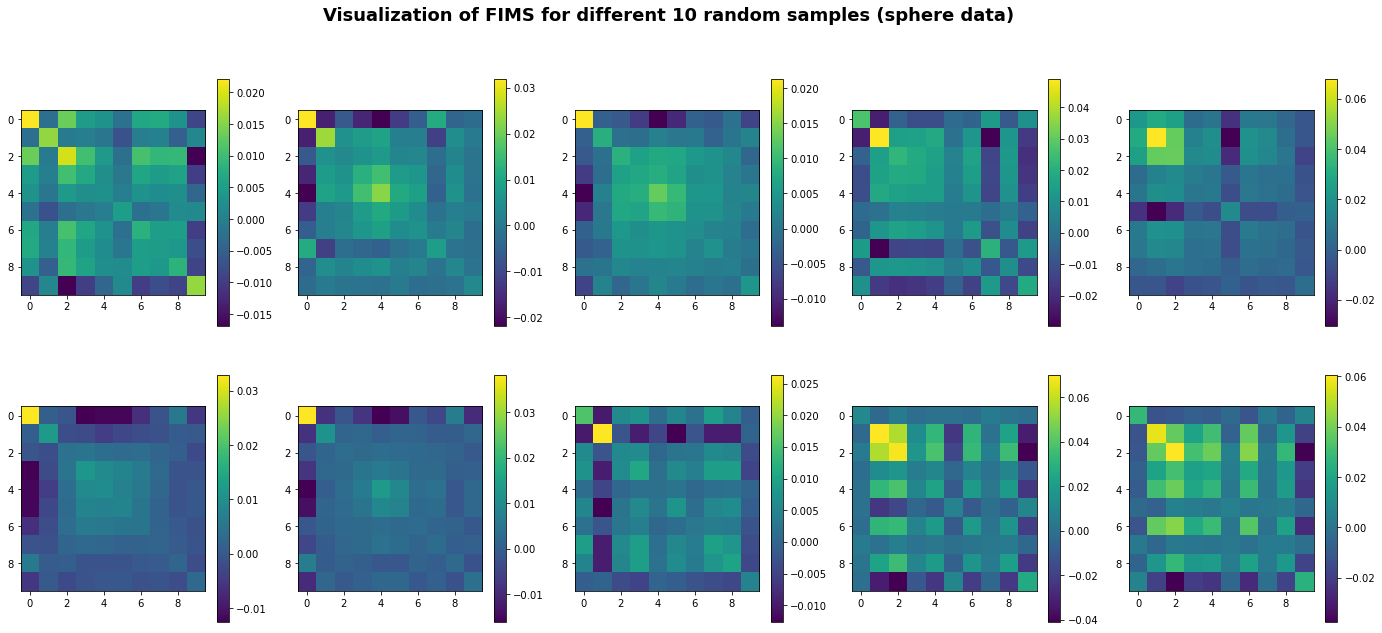

In [104]:
plt.figure(figsize = (24,10))
plt.suptitle("Visualization of FIMS for different 10 random samples (sphere data)",fontsize=18,fontweight='bold')
for i in range(len(rint)):
    plt.subplot(2,5,i+1)
    plt.imshow(fishermat[rint[i],:,:])
    plt.colorbar()

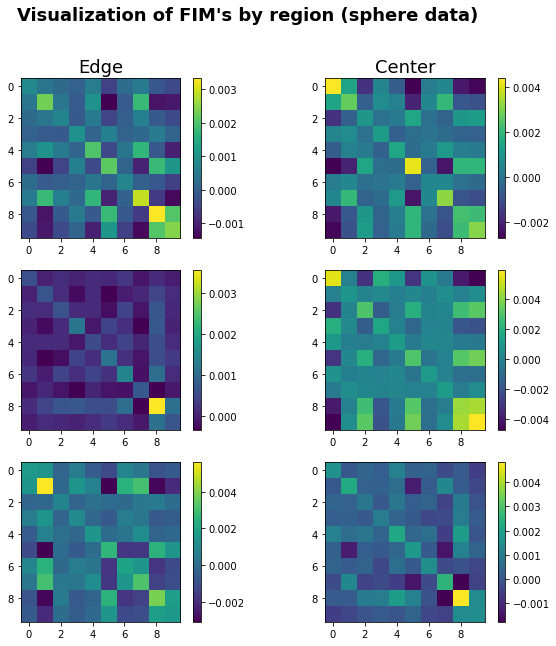

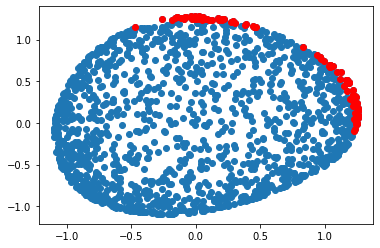

In [23]:

#Compute and sort embedding distances
distind = np.argsort(np.linalg.norm((predemb - predemb.mean(0)),axis=1))
plt.figure(figsize = (10,10))
plt.suptitle("Visualization of FIM's by region (sphere data)",fontsize=18,fontweight='bold')

a = int(len(distind)) -1 #specifies index in sorted vector to get edges

for i in range(6):
    plt.subplot(3,2,i+1)
    
    if i == 1 or i == 3 or i == 5: #(for plotting)
        if i == 1:
            plt.title("Center",fontsize=18)
        plt.imshow(fishermat[distind[i],:,:])
        plt.colorbar()
        
    else:
        if i == 0: #(for plotting)
            plt.title("Edge",fontsize=18)
        plt.imshow(fishermat[distind[a],:,:])
        plt.colorbar()
        
    a = a - 1
    
plt.savefig("Figures/1500_sphere_regional_FIMs_1_17.png")

plt.figure()
plt.scatter(predemb[:,0],predemb[:,1])
plt.scatter(predemb[distind[1400:],0],predemb[distind[1400:],1],c='red')

# PBMC Data

In [7]:
#extract PMBC data size/dimensions

initdir = os.getcwd()
os.chdir(os.path.abspath('..') + '/src/data')
with open('pbmc.pickle','rb') as f:
    X = pickle.load(f).values.squeeze()
os.chdir(initdir)


trainobs = 900
traind = random.sample(range(0,X.shape[0]),trainobs)
iX = X[traind,:]

print(iX.shape)
print(X.shape)

(900, 1838)
(2638, 1838)


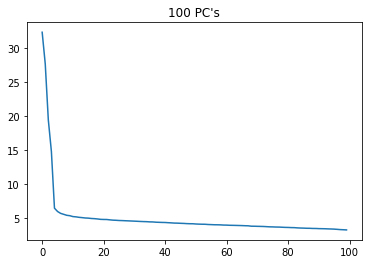

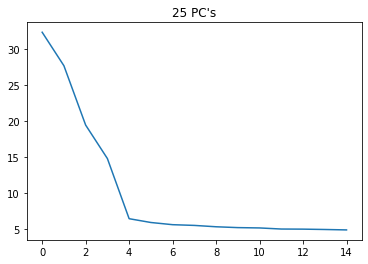

In [8]:
#Apply PCA TO Reduce the dimensions
n_dim = 25
#100 PCs
pca = PCA(n_components=100)
pca.fit(iX)
trainX = iX @ pca.components_.T

plt.figure()
plt.title("100 PC's")
plt.plot(pca.explained_variance_)


#25 PCs
pca = PCA(n_components=15)
pca.fit(iX)
trainX = iX @ pca.components_.T

plt.figure()
plt.title("25 PC's")
plt.plot(pca.explained_variance_)

In [ ]:
#Evaluate Ground Truth with MDS


phate_op = phate.PHATE(random_state=42, verbose=False, knn=20,t=150).fit(trainX)#.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_PBMC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())


In [ ]:
#distind = np.argsort(np.linalg.norm((predemb - predemb.mean(0)),axis=1))

Text(0, 0.5, 'PHATE axis 2')

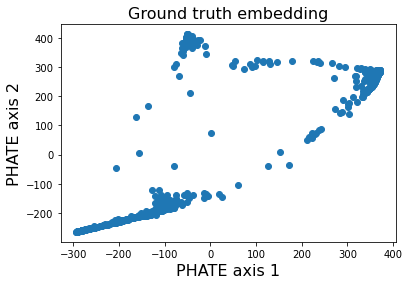

In [92]:

plt.figure()
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phateJSDemb_PBMC[:,0],phateJSDemb_PBMC[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
#plt.xlim(-40,40)
#plt.ylim(-50,0)


In [95]:
np.save("saved_data/1500_JSDmds_phate.npy",phateJSDemb_PBMC)

In [24]:
phate_op = phate.PHATE(random_state=42, verbose=False, knn=3,t=80).fit(trainX)#.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )

mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_PBMC_two = mds_operator.fit_transform(gtdist.detach().cpu().numpy())

Text(0, 0.5, 'PHATE axis 2')

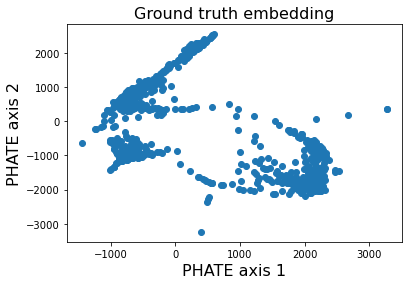

In [25]:
plt.figure()
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phateJSDemb_PBMC_two[:,0],phateJSDemb_PBMC_two[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
#plt.xlim(-1100,1100)
#plt.ylim(-2000,1000)


In [26]:
np.save("saved_data/1500_pbmc_1_24_JSD_phate_two.npy",phateJSDemb_PBMC_two)

In [77]:
pbmc_data, pbmc_emb = make_pbmc(n_obs=trainX.shape[0],emb_dim=2,knn=10,indx=traind)

Text(0, 0.5, 'PHATE axis 2')

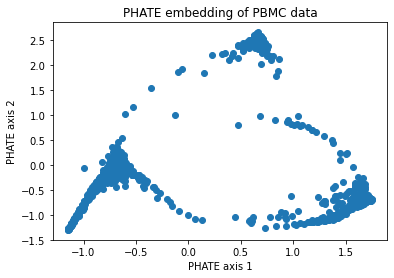

In [78]:
plt.figure()
plt.title("PHATE embedding of PBMC data")
plt.scatter(pbmc_emb[:,0],pbmc_emb[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

In [13]:
print(n_dim)

25


In [20]:
# Data Parameters
dataset = "pbmc"
n_obs = trainX.shape[0]
n_dim = 15
batch_size = 50

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "pbmc_phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 20 # PHATE kernel number of Nearest Neighbors.
logp=False

# Trainer param
max_epochs = 100
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "pbmc_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [5]:
print(len(traind))
print(n_dim)
print(X[traind,:])

1500
25
[[ 4.1608415  -0.25326306 -0.04839117 ... -0.06250995 -0.15432826
  -0.49168196]
 [-0.2525195   3.4016316  -0.04984321 ... -0.09238634 -0.17265882
  -0.5031953 ]
 [-0.20190424 -0.2687164  -0.04734872 ... -0.08228047 -0.1855075
  -0.5142381 ]
 ...
 [-0.22707514 -0.27224866 -0.04879574 ... -0.09280943 -0.18307401
  -0.51132184]
 [-0.35442075 -0.32007253 -0.05808897 ... -0.19863845 -0.20854625
   1.1786985 ]
 [-0.20558618 -0.28444356 -0.04856196 ... -0.11051115 -0.20433842
  -0.5263014 ]]


In [21]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="pbmc_autoenocder_logp", name=exp_name) if wandb else False

In [22]:
PATH = os.getcwd()
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH,indx=traind)

In [23]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH)

# Defining the pytorch lightning model.
model_pbmc = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_pbmc, train_dataloaders=train_loader)

Global seed set to 774


[Linear(in_features=15, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 16.8 K
1 | decoder | Sequential | 242   
---------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [24]:
#save model (and load model)

torch.save(model_pbmc.state_dict(),'saved_models/pbmc_model_1_24.pt')
#model.load_state_dict(torch.load('saved_models/pbmc_model_1_18.pt'))

# Beginning of Junk

In [11]:

#model_pbmc = LitAutoencoder(input_dim=n_dim,emb_dim=emb_dim)
#model_pbmc.load_state_dict(torch.load('/home/of56/FIM_farnam/notebooks/saved_models/pbmc_model_1_17_retry.pt'))

testind = list( set(list(np.arange(X.shape[0]))) - set(traind))
pbmc_data, pbmc_phate = make_pbmc(n_obs=len(testind),emb_dim=2,knn=knn,indx=testind)

pbmc_data = pbmc_data.to('cuda')
model_pbmc.cuda()
model_pbmc.eval()
pred = model_pbmc.encode(pbmc_data).detach().cpu().numpy()

#mds_operator = MDS()
#predemb = mds_operator.fit_transform(pred)
#print(predemb.shape)

In [14]:


phate_op = phate.PHATE(random_state=42, verbose=False, knn=knn,t=50).fit(pbmc_data.detach().cpu().numpy())#.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )

mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_PBMC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())


# End of Junk

In [25]:
#Getting predictions


testind = list( set(list(np.arange(X.shape[0]))) - set(traind))
pbmc_data, pbmc_phate = make_pbmc(n_obs=len(testind),emb_dim=2,knn=knn,indx=testind)

pbmc_data = pbmc_data.to('cuda')
model_pbmc.cuda()
model_pbmc.eval()
pred = model_pbmc.encode(pbmc_data).detach().cpu().numpy()

print(pred.shape)

#mds_operator = MDS()
#predemb = mds_operator.fit_transform(pred)

#print(predemb.shape)


#Performing ground JSD MDS
phate_op = phate.PHATE(random_state=42, verbose=False, knn=20,t=150).fit(pbmc_data.detach().cpu().numpy())#.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()
gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_PBMC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())



(1738, 50)


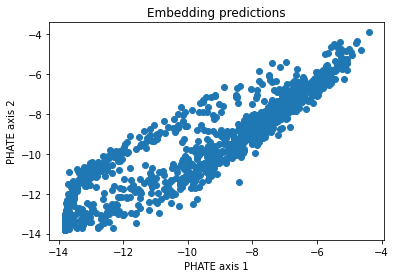

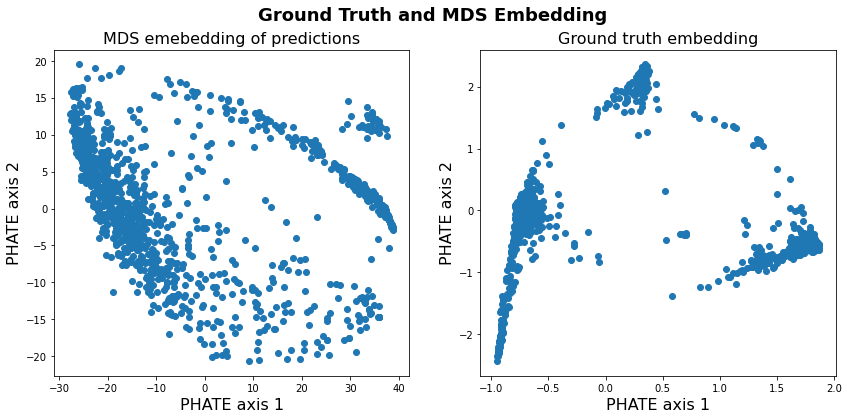

In [87]:

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure(figsize = (14,6))
plt.suptitle("Ground Truth and MDS Embedding",fontweight='bold',fontsize=18)
plt.subplot(121)
plt.title("MDS emebedding of predictions",fontsize=16)
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.subplot(122)
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(pbmc_phate[:,0],pbmc_phate[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


np.save("saved_data/1500_pbmc_1_21_1500_pred.npy",pred)
np.save("saved_data/1500_pbmc_1_21_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_pbmc_1_21_1500_ground_truth.npy",pbmc_phate)
plt.savefig("Figures/1500_pbmc_1_21_1500_ground_truth.png")

In [26]:

#Compute FIM 
n_obs = len(testind)
model_pbmc.cuda()
fcn = model_pbmc.encode
fisher = FIM(pbmc_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
#tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
#model_pbmc.eval()
#vout = model_pbmc.encode(tvec).squeeze()
#neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


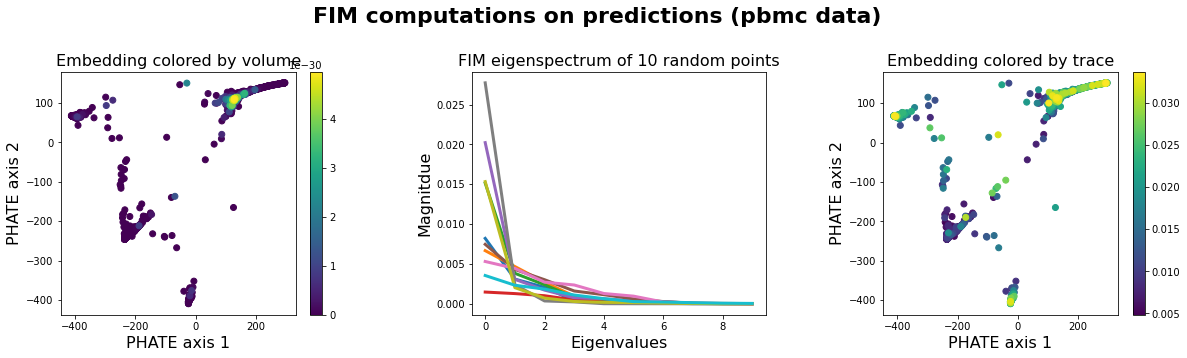

In [29]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])

#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


#plt.figure(figsize=(14,10))
#plt.suptitle("FIM computations on predictions (pbmc data) ",fontsize=22,fontweight='bold')
#plt.subplots_adjust(hspace=0.4,wspace=0.4)

plt.figure(figsize=(20,5))
plt.suptitle("FIM computations on predictions (pbmc data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=1.0,wspace=0.4,top=0.8)


#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(131)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(phateJSDemb_PBMC[vind, 0], phateJSDemb_PBMC[vind, 1], c= nvolume)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,len(testind),size=10)
plt.subplot(132)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:10],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)


#Trace
plt.subplot(133)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(phateJSDemb_PBMC[tind, 0], phateJSDemb_PBMC[tind, 1], c= ntrace)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
plt.colorbar()




#Visualization of eignevectors
#reint = np.random.randint(0,pbmc_phate.shape[0],size=500) #Random 
#plt.subplot(224)
#plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
#plt.scatter(predemb[reint,0],predemb[reint,1])
#plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=30)
#plt.xlabel("PHATE axis 1",fontsize=16)
#plt.ylabel("PHATE axis 2",fontsize=16)
plt.savefig("Figures/pbmc_FIMcomps_1_24.png")

# IPSC Data

In [55]:
#load data
initdir = os.getcwd()
os.chdir(os.path.abspath('..') + '/src/data')
X = sio.loadmat('ipscData.mat')['data']
os.chdir(initdir)

In [18]:
print(X.shape)

(220450, 33)


In [56]:
#Get ipsc embedding
n_obs=1500
traind = random.sample(range(0,X.shape[0]),n_obs)
ipsc_data, ipsc_emb = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=traind)




In [20]:
print(ipsc_data.shape)

torch.Size([1500, 33])


In [ ]:

#Ground truth embedding with subset of IPSC data
phate_op = phate.PHATE(random_state=42, verbose=False, knn=10,t=270).fit(ipsc_data.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )

mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_IPSC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())

In [37]:
np.save("saved_data/phateJSDemb_IPSC.npy",phateJSDemb_IPSC)

Text(0, 0.5, 'PHATE axis 2')

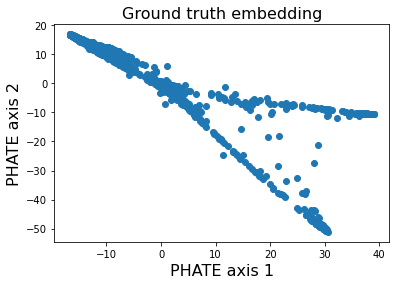

In [30]:

plt.figure()
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phateJSDemb_IPSC[:,0],phateJSDemb_IPSC[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
#plt.xlim(-1100,1100)
#plt.ylim(-2000,1000)


Text(0, 0.5, 'PHATE axis 2')

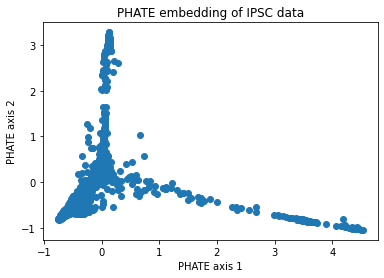

In [6]:
#IPSC data
plt.figure()
plt.title("PHATE embedding of IPSC data")
plt.scatter(ipsc_emb[:,0],ipsc_emb[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

In [59]:
# Data Parameters
dataset = "ipsc"
n_obs = n_obs
n_dim = X.shape[1]
batch_size = 50

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "ipsc_phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.00  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=False

# Trainer param
max_epochs = 150
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "ipsc_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [60]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="ipsc_autoenocder_logp", name=exp_name) if wandb else False

In [61]:
PATH = os.getcwd()
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH,indx=traind)

In [128]:
print(len(traind))

15000


In [62]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH)

# Defining the pytorch lightning model.
model_ipsc = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_ipsc, train_dataloaders=train_loader)

Global seed set to 740


[Linear(in_features=33, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 18.6 K
1 | decoder | Sequential | 242   
---------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [51]:
#save model (and load model)

torch.save(model_ipsc.state_dict(),'saved_models/ipsc_model_1_25.pt')
#model.load_state_dict(torch.load('saved_models/ipsc_model_1_18.pt'))

In [22]:
print(len(traind))

1500


In [63]:

#Getting predictions

n_obs=1500
nontrain = list( set(list(np.arange(X.shape[0]))) - set(traind))
testind = random.sample(nontrain,n_obs)
ipsc_data, ipsc_phate = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=testind)

print(ipsc_data.shape)

ipsc_data = ipsc_data.to('cuda')
model_ipsc.cuda()
model_ipsc.eval()
pred = model_ipsc.encode(ipsc_data).detach().cpu().numpy()

print(pred.shape)

#mds_operator = MDS()
#predemb = mds_operator.fit_transform(pred)
#print(predemb.shape)
#Performing ground JSD MDS

phate_op = phate.PHATE(random_state=42, verbose=False, knn=10,t=270).fit(ipsc_data.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()
gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_IPSC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())




torch.Size([1500, 33])
(1500, 50)


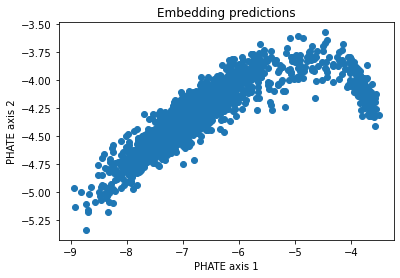

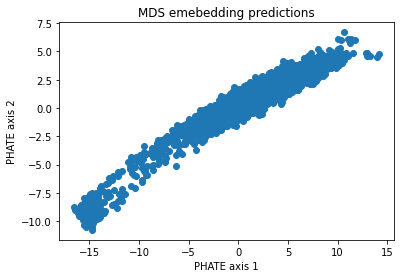

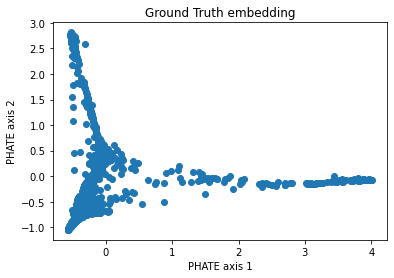

In [27]:

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("MDS emebedding predictions")
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("Ground Truth embedding")
plt.scatter(ipsc_phate[:,0],ipsc_phate[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")



np.save("saved_data/1500_ipsc_1_21_1500_pred.npy",pred)
np.save("saved_data/1500_ipsc_1_21_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_ipsc_1_21_1500_ground_truth.npy",ipsc_phate)
plt.savefig("Figures/1500_ipsc_1_21_1500_ground_truth.png")

In [64]:

#Compute FIM 
model_ipsc.cuda()
fcn = model_ipsc.encode
fisher = FIM(ipsc_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
#tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
#model_ipsc.eval()
#vout = model_ipsc.encode(tvec).squeeze()
#neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


In [19]:
print(volume)

[0. 0. 0. ... 0. 0. 0.]


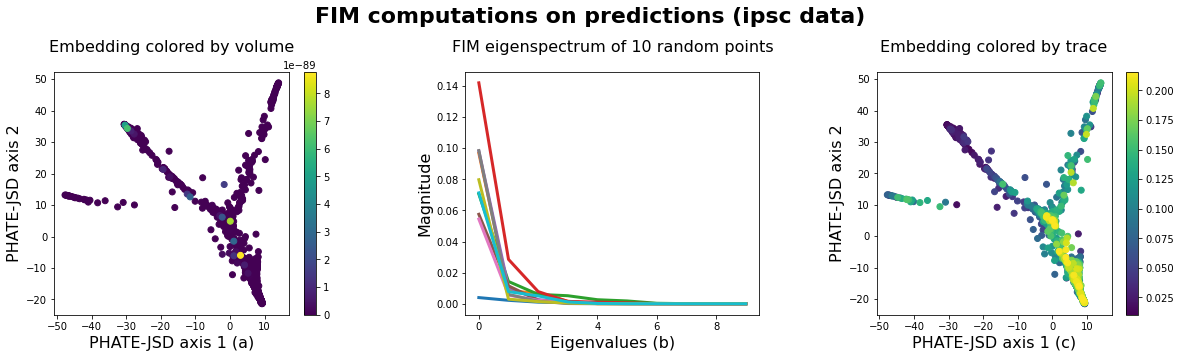

In [65]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 


#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


#plt.figure(figsize=(14,10))
#plt.suptitle("FIM computations on predictions (ipsc data) ",fontsize=22,fontweight='bold')
#plt.subplots_adjust(hspace=0.4,wspace=0.4)

plt.figure(figsize=(20,5))
plt.suptitle("FIM computations on predictions (ipsc data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=1.0,wspace=0.4,top=0.8)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(131)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(phateJSDemb_IPSC[vind, 0], phateJSDemb_IPSC[vind, 1], c= nvolume)
plt.xlabel("PHATE-JSD axis 1 (a)",fontsize=16)
plt.ylabel("PHATE-JSD axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,len(testind),size=10)
plt.subplot(132)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:10],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues (b)",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)


#Trace
plt.subplot(133)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(phateJSDemb_IPSC[tind, 0], phateJSDemb_IPSC[tind, 1], c= ntrace)
plt.xlabel("PHATE-JSD axis 1 (c)",fontsize=16)
plt.ylabel("PHATE-JSD axis 2",fontsize=16)
plt.colorbar()



#Visualization of eignevectors
#reint = np.random.randint(0,ipsc_phate.shape[0],size=1000) #Random 
#plt.subplot(224)
#plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
#plt.scatter(predemb[reint,0],predemb[reint,1])
#plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=15)
#plt.xlabel("PHATE axis 1",fontsize=16)
#plt.ylabel("PHATE axis 2",fontsize=16)
plt.savefig("Figures/ipsc_FIMcomps_1_25.png")
np.save("saved_data/ipsc_1_25_1500_ground_truth_JSD.npy",phateJSDemb_IPSC)
np.save("saved_data/ipsc_1_25_ind.npy",tind)
np.save("saved_data/ipsc_1_25_1500_trace.npy",ntrace)
np.save("saved_data/ipsc_1_25_1500_volume.npy",nvolume)